## 3D Image construction from single 2D image using pre-trained model.

Install required libraries (run this first)

In [121]:
!pip install transformers open3d matplotlib

Import libraries

In [122]:
import matplotlib.pyplot as plt
import open3d as o3d
from PIL import Image
import numpy as np
import torch
from transformers import DPTImageProcessor, DPTForDepthEstimation
from google.colab import files
import io
import os

Load the depth estimation model

In [123]:
image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)

 Upload and display the image

Please upload your image:


Saving HEART.png to HEART.png
Image 'HEART.png' uploaded successfully!
Image size: (371, 469)
Image format: PNG
Image mode: RGBA


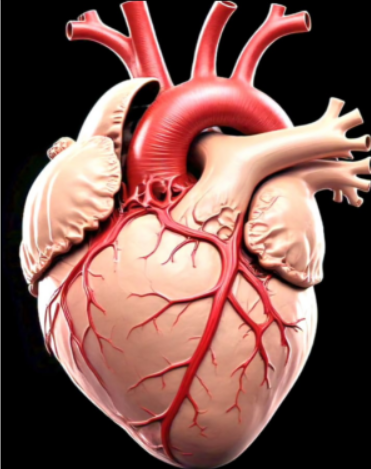

In [124]:
# Upload an image file
print("Please upload your image:")
uploaded = files.upload()

# Get the filename of the uploaded image
filename = list(uploaded.keys())[0]

# Open the uploaded image using PIL and assign it to a variable
image = Image.open(io.BytesIO(uploaded[filename]))

# Display image information
print(f"Image '{filename}' uploaded successfully!")
print(f"Image size: {image.size}")
print(f"Image format: {image.format}")
print(f"Image mode: {image.mode}")

# Display the image
display(image)

Resize the image to be compatible with the model

In [125]:
new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32
new_width = new_width - diff if diff < 16 else new_width + (32 - diff)
new_size = (new_width, new_height)
image = image.resize(new_size)
print(f"Image resized to {new_size}")

Image resized to (352, 448)


Process image and get depth prediction

In [126]:
# Convert to RGB to ensure compatibility
image_rgb = image.convert("RGB")

# Prepare the image for the model
inputs = image_processor(images=image_rgb, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# Process the depth output
pad = 2
output = predicted_depth.squeeze().cpu().numpy() * 1000.0
output = output[pad:-pad, pad:-pad]
image_cropped = image_rgb.crop((pad, pad, image_rgb.width - pad, image_rgb.height - pad))

Visualize the original image and depth map

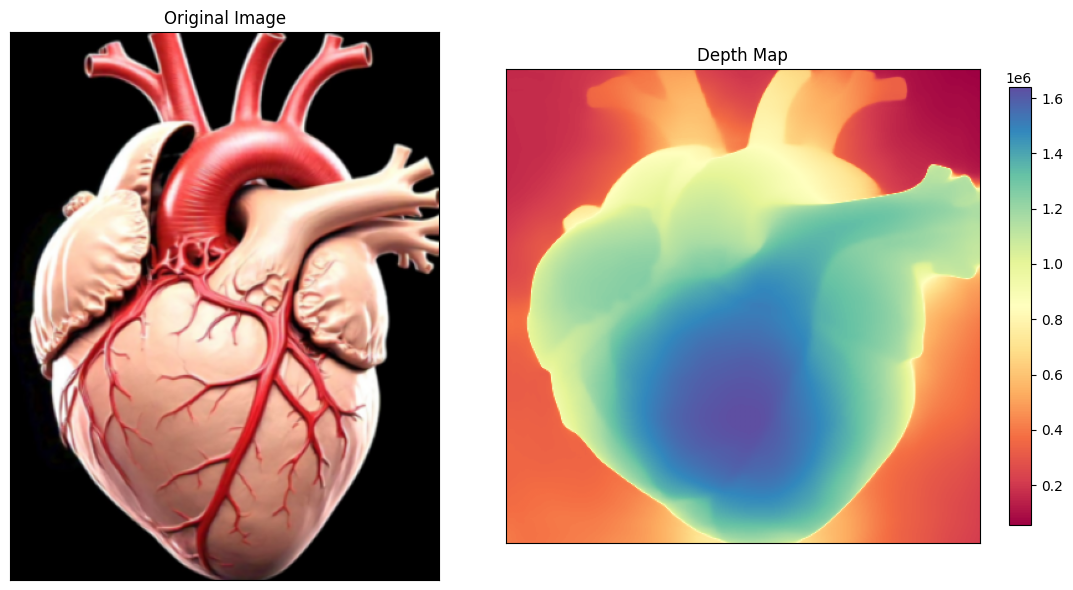

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_cropped)
ax[0].set_title("Original Image")
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
depth_vis = ax[1].imshow(output, cmap='Spectral')
ax[1].set_title("Depth Map")
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.colorbar(depth_vis, ax=ax[1], shrink=0.8)
plt.tight_layout()
plt.show()

In [128]:
# Cell 8: Create point cloud from the depth image
width, height = image_cropped.size

# Convert depth to a format usable by Open3D
depth_image = (output * 255 / np.max(output)).astype('uint8')

# Resizing depth_image to match color image dimensions
depth_image = Image.fromarray(depth_image).resize(image_cropped.size)
depth_image = np.array(depth_image)
image_np = np.array(image_cropped)

# Create RGBD image
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image_np)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image_o3d, depth_o3d, convert_rgb_to_intensity=False)

# Define camera parameters
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width, height, 500, 500, width / 2, height / 2)

# Generate the raw point cloud
pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
print("Raw point cloud created")

Raw point cloud created


Clean the point cloud (remove outliers)

In [129]:
cl, ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd = pcd_raw.select_by_index(ind)
print("Outliers removed from point cloud")

Outliers removed from point cloud


Estimate normals for the point cloud

In [130]:
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()
print("Normals estimated")

Normals estimated


Save the point cloud file

In [131]:
# Create output directory
output_dir = "pointclouds"
os.makedirs(output_dir, exist_ok=True)

# Define file path - using the original filename without extension
base_filename = os.path.splitext(filename)[0]
pcd_file = os.path.join(output_dir, f"{base_filename}.ply")

# Save the point cloud
o3d.io.write_point_cloud(pcd_file, pcd)
print(f"Point cloud saved to: {pcd_file}")

Point cloud saved to: pointclouds/HEART.ply


Create mesh from point cloud

In [132]:
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, n_threads=1)[0]
print("Mesh created using Poisson reconstruction")

Mesh created using Poisson reconstruction


Rotate the mesh (if needed)

In [133]:
rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
mesh.rotate(rotation, center=(0, 0, 0))
print("Mesh rotated")

Mesh rotated


Save the mesh file

In [134]:
# Create output directory
output_dir = "mesh"
os.makedirs(output_dir, exist_ok=True)

# Define file path - using the original filename without extension
base_filename = os.path.splitext(filename)[0]
mesh_file = os.path.join(output_dir, f"{base_filename}.obj")

# Save the mesh
o3d.io.write_triangle_mesh(mesh_file, mesh)
print(f"Mesh file saved to: {mesh_file}")

Mesh file saved to: mesh/HEART.obj
